In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import bp_pas.params as params
import bp_pas.corpus as corpus
import bp_pas.stats as stats
from bp_pas.eval import evaluate
from bp_pas.util.vocab import Vocab

import sys
import gflags
import tensorflow as tf
import numpy as np

In [3]:
params.load_defaults()
flags = gflags.FLAGS
#arg_str = '' #'--train_data single.utf8 --dev_data single.utf8 --test_data single.utf8'
arg_str = '--max_train_instances 1 --use_context=true --use_sp=false --context_dims 200' #'--train_data single.utf8 --dev_data single.utf8 --test_data single.utf8'
args = [''] + arg_str.split(' ')
argv = flags(args)
print(flags.use_context)

True


In [4]:
# tmp params to add to flags
unk_threshold = 1
unk_token = '<UNK>'

if not flags.use_context:
    flags.context_dims = 0
if not flags.use_sp:
    flags.sp_dims = 0

synt_arg_embedding_size = flags.context_dims
sem_arg_embedding_size = flags.sp_dims

complete_embedding_size = synt_arg_embedding_size + sem_arg_embedding_size
num_training_instances = 1

assert complete_embedding_size % 2 == 0
print(complete_embedding_size)


200


In [5]:
# Load data
print(flags.train_data)
ntc = corpus.NTCLoader()
train_data = ntc.load_corpus(flags.train_data, flags.max_train_instances)
test_data  = ntc.load_corpus(flags.test_data, flags.max_train_instances)
dev_data   = ntc.load_corpus(flags.dev_data, flags.max_train_instances)
print('{} train sentences.'.format(len(train_data)))
print('{} test sentences.'.format(len(test_data)))
print('{} dev sentences.'.format(len(dev_data)))
stats.corpus_statistics(train_data)
stats.show_case_dist(train_data)

data/NTC_1.5/processed/train.utf8
1 train sentences.
1 test sentences.
1 dev sentences.

CORPUS STATISTICS
	Docs: 1  Sents: 1  Words: 71
	Predicates: 9  Arguments 15



CASE DISTRIBUTION
	Ga	BST: 0  DEP: 2  INTRA-ZERO: 7  INTER-ZERO: 0  EXOPHORA: 0
	O	BST: 0  DEP: 2  INTRA-ZERO: 0  INTER-ZERO: 0  EXOPHORA: 0
	Ni	BST: 0  DEP: 4  INTRA-ZERO: 0  INTER-ZERO: 0  EXOPHORA: 0

	Predicates: 9


In [6]:
# Unpack data from "docs"->sents
train_data = train_data[0]
test_data  = test_data[0]
dev_data   = dev_data[0]
print('{} train sentences.'.format(len(train_data)))
print('{} test sentences.'.format(len(test_data)))
print('{} dev sentences.'.format(len(dev_data)))

1 train sentences.
1 test sentences.
1 dev sentences.


In [7]:
# Setup vocabulary
all_sents = train_data + test_data + dev_data
print('Number of total sentences: {}'.format(len(all_sents)))

print('Collecting all tokens...')
word_tokens = list(word.form
                   for sent in all_sents
                   for word in sent)
print('Total tokens: {}\n'.format(len(word_tokens)))

print('Building (argument) vocabulary...')
arg_vocab = Vocab(init_words=word_tokens, 
                  unk_token=unk_token, 
                  unk_threshold=unk_threshold)
arg_vocab.freeze()
arg_vocabulary_size = len(arg_vocab)
print('Vocabulary size: {}\n'.format(arg_vocabulary_size))

print('Collecting predicates...')
pred_vocab = Vocab(init_words=[word.form
                               for sent in all_sents
                               for word in sent if word.is_prd])
pred_vocab.freeze()
pred_vocabulary_size = len(pred_vocab)
print('Number of predicates: {}\n'.format(pred_vocabulary_size))

print('Collecting argument types...')
arg_types = ['NIL'] + list(set([arg.arg_type 
                      for sent in all_sents 
                      for pas in sent.pas
                      for arg in pas.args]))
print('Arg types: ', arg_types)
num_types = len(arg_types)

#print(pred_vocab.elems())

Number of total sentences: 3
Total tokens: 157

Building (argument) vocabulary...
Vocabulary size: 80

Number of predicates: 14

Arg types:  ['NIL', 'GA', 'O', 'NI']


In [8]:
# Convert data structures into numpy ndarrays for placeholders
from bp_pas.util.feed_dict_helper import separate_pred_dicts

train_dicts = [ex 
               for td in train_data 
               for ex in separate_pred_dicts(td, pred_vocab, arg_vocab, arg_types)]

test_dicts = [separate_pred_dicts(td, pred_vocab, arg_vocab, arg_types)
              for td in train_data]

# Just for now
test_data = train_data
print(len(train_dicts))
print(len(test_dicts))

9
1


In [12]:
# Setup the context embedding
tf.reset_default_graph()

# Construct syntactic embedding matrix for contex/arguments
synt_arg_embeddings = tf.Variable(tf.random_uniform([arg_vocabulary_size, synt_arg_embedding_size], -1.0, 1.0, dtype=tf.float64), trainable=False)

# Construct semantic embedding matrix for selectional preference
sem_arg_embeddings = tf.Variable(tf.random_uniform([arg_vocabulary_size, sem_arg_embedding_size], -1.0, 1.0, dtype=tf.float64), trainable=False)

# Construct embedding matrix for predicates
pred_embeddings = tf.Variable(tf.random_uniform([pred_vocabulary_size, num_types * complete_embedding_size], -1.0, 1.0, dtype=tf.float64), trainable=True)

# Setup placeholders
batch_size = 1
sent_placeholder = tf.placeholder(tf.int32, shape=[None])
pred_placeholder = tf.placeholder(tf.int32, shape=[None])
gold_placeholder = tf.placeholder(tf.float64, shape=[num_types, None])

from bp_pas.model.baseline import Model

model = Model(pred_embeddings, synt_arg_embeddings, sem_arg_embeddings,
              sent_placeholder, pred_placeholder, gold_placeholder, flags)


rep = model.complete_embeddings(sent_placeholder, sem_arg_embeddings, synt_arg_embeddings, synt_arg_embedding_size)
scored_mat_opt = model.pred_full_scoring(pred_placeholder, pred_embeddings, rep)


In [10]:
def meta_decode(sess, instance):
#    print('In decode')
    # Collect model-scores labels-x-tokens mats
    int_inputs = separate_pred_dicts(instance, pred_vocab, arg_vocab, arg_types)
#    print('plen: ', len(int_inputs))
    scored_mats = []
    for sent_ids, pred_ids, gold_labels in int_inputs:
        feed_dict={
            sent_placeholder: sent_ids,
            pred_placeholder: pred_ids,
            gold_placeholder: gold_labels
        }
        scored_mats.append(sess.run(scored_mat_opt, feed_dict=feed_dict))
#        print(gold_labels)
#        print('\n')
#        print(scored_mats[-1])
#        print('------------------------')
    # 
#    print('scored ', len(scored_mats))
    pred_indices = [i for i, w in enumerate(instance.words) if w.is_prd]
    num_preds = len(pred_indices)
    pases = []
    for pred_id, scored_mat in zip(pred_indices, scored_mats):
        #        print(pred_id)
        pred = Predicate(word_index=pred_id,
                         word_form=instance.words[pred_id].form)
        args = []
        for slot, slot_id in zip(arg_types, range(num_types)):
            if slot != 'NIL':
                max_index = np.argmax(scored_mat[slot_id])
#                print(slot, ': ', max_index)
                args.append(Argument(word_index=max_index,
                                     word_form=instance.words[max_index].form,
                                     arg_type=slot))
                #                print('\t', max_index)
        pases.append(PAS(pred, args))
#        print('psize: ', len(pases))
    return Sentence(instance.words, pases)

In [13]:
from bp_pas.eval import evaluate
from bp_pas.ling.pas import PAS, Predicate, Argument
from bp_pas.ling.sent import Sentence

sess = tf.Session()
sess.run(tf.global_variables_initializer())

opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)
loss = model.loss_old(gold_placeholder, pred_placeholder, pred_embeddings, rep)
opt_op = opt.minimize(loss)

num_epochs = 10000
for epoch in range(num_epochs):
    epoch_loss = 0
    for train_dict in train_dicts:
        sent_ids, pred_ids, gold_labels = train_dict
#        print(gold_labels.shape)
        _, closs = sess.run([opt_op, loss], feed_dict = {
            sent_placeholder: sent_ids,
            pred_placeholder: pred_ids,
            gold_placeholder: gold_labels
        })
        epoch_loss += closs.mean()
    if epoch > 0 and epoch % 1000 == 0:
        decoded = [pas
                   for tsent in train_data
                   for pas in meta_decode(sess, tsent).pas ]#[0:1]
#        decoded = [pas 
#                   for tsent, tdict in zip(train_data, train_dicts)
#                   for pas in meta_decode(sess, tsent)] # #model.decode(sess, tsent, tdict).pas]
        gold = [pas 
                for sent in train_data
                for pas in sent.pas]#[0:1]
        evaluate(decoded, gold, verbose=False)
        print('{0:>4}: {1:.3f}'.format(epoch, epoch_loss))


Prec = (14/27) = 51.851851851851855
Rec  = (14/15) = 93.33333333333333
1000: 0.062
Prec = (14/27) = 51.851851851851855
Rec  = (14/15) = 93.33333333333333
2000: 0.057
Prec = (14/27) = 51.851851851851855
Rec  = (14/15) = 93.33333333333333
3000: 0.055
Prec = (14/27) = 51.851851851851855
Rec  = (14/15) = 93.33333333333333
4000: 0.055


KeyboardInterrupt: 

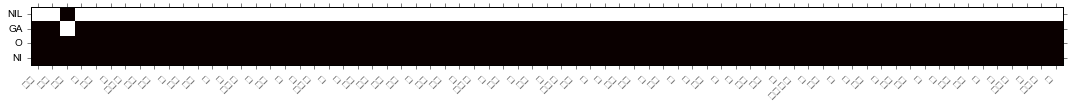

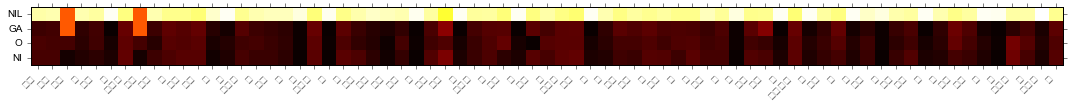

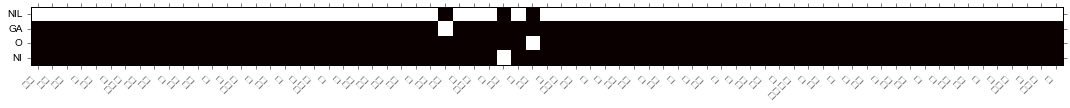

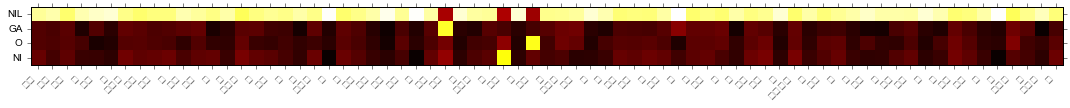

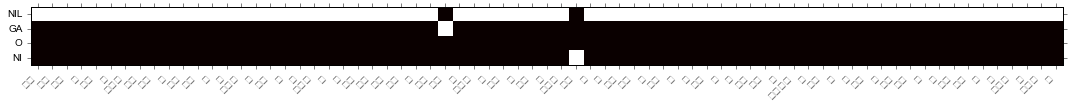

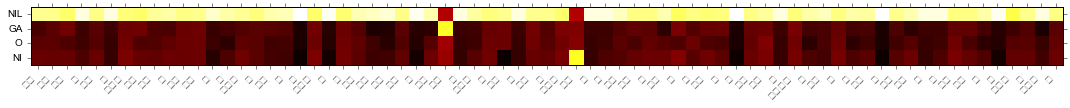

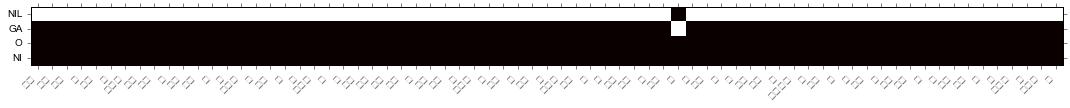

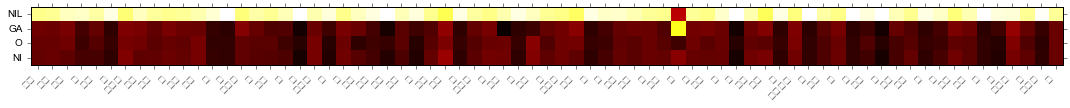

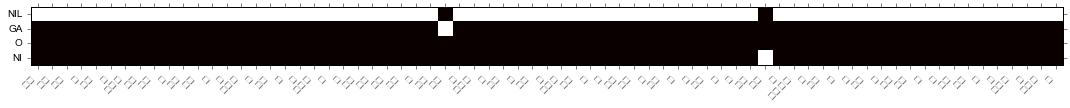

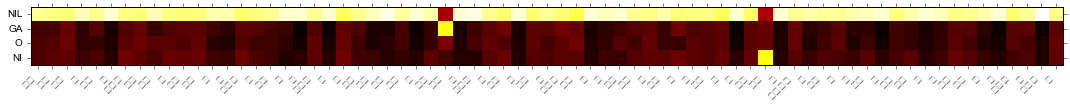

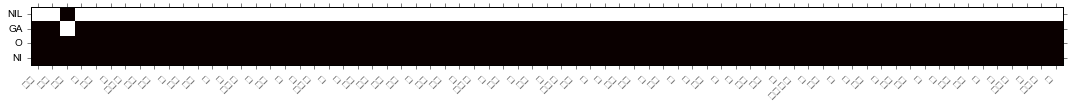

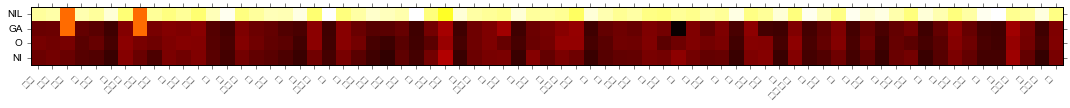

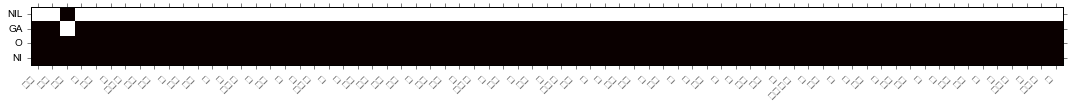

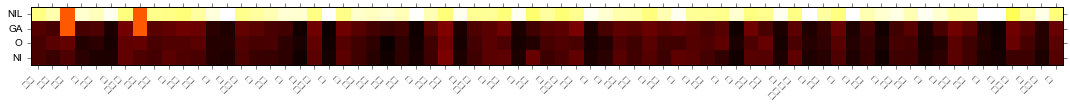

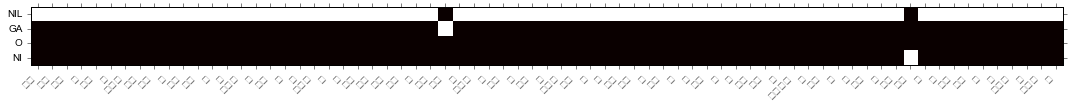

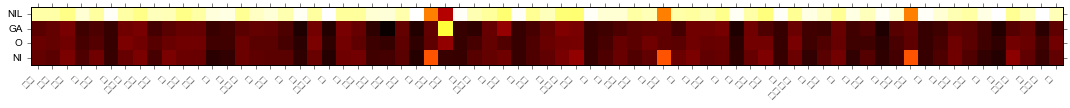

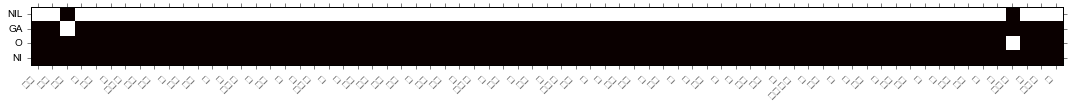

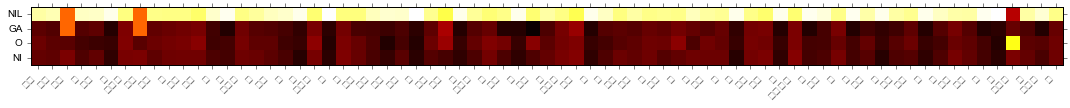

In [15]:
# Visualization
from __future__ import unicode_literals
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
#matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rc('font', **{'sans-serif' : 'Arial',
                           'family' : 'sans-serif'})


def heatmap_plot_comp(sess, instance):
    words = [w.form for w in instance.words]
    pred_dicts = separate_pred_dicts(instance, pred_vocab, arg_vocab, arg_types)
    for pred_dict in pred_dicts:
        sent_ids, pred_ids, gold_labels = pred_dict
        scores = sess.run(scored_mat_opt, feed_dict = {
                sent_placeholder: sent_ids,
                pred_placeholder: pred_ids,
                gold_placeholder: gold_labels        
        })
#        pred_indices = [i for i, w in enumerate(instance.words) if w.is_prd]
#        num_preds = len(pred_indices)
#        scored_by_pred = np.split(scores, indices_or_sections=num_preds, axis=1)
#        gold_by_pred = np.split(gold_labels, indices_or_sections=num_preds, axis=1)
        sentence_heatmap(gold_labels, arg_types, words)
        sentence_heatmap(scores, arg_types, words)



def sentence_heatmap(scores, slots, words):
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax1 = fig.add_subplot(111)
    ax1.imshow(scores, cmap='hot', interpolation='nearest')
    
    ax1.tick_params(direction='out')
    ax1.set_yticks(range(len(arg_types)))
    ax1.set_yticklabels(arg_types, minor=False)

    ax1.set_xticks(range(len(words)))
    ax1.set_xticklabels(words, rotation=45, ha='right')

#    ax2 = fig.add_subplot(211)
#    ax2.imshow(gold_mat, cmap='hot', interpolation='nearest')

    plt.show()
    fig.savefig('/Users/narad/Desktop/test2png.png', dpi=100)
#    print(gold_mat)
#    print(scored_mat)

heatmap_plot_comp(sess, train_data[0])


In [ ]:

#feed_dict = {sent_placeholder: sent_ids, pred_placeholder: pred_ids}
#context_out = sess.run(context_rep, feed_dict=feed_dict)
#print(context_out.shape)
#out = sess.run(pred_scores, feed_dict=feed_dict)
#print(out)
#print(out.shape)
#print(out[0].shape)

# 1, 9, 8

#want 1, 9, 1

# context mat is 71, 8

# pred mat is 8, 36

# after mult is 71 x 36

#def pred_single_scoring(single_pred_set, single_context, num_slots, num_preds):
#    return single_pred_set
#    single_pred = tf.unstack(single_pred_set, num=num_preds)[0]
#    return tf.transpose(single_pred)
#    return tf.matmul(single_context, tf.transpose(single_pred))







#def pas2matrix(pas):
    


#def sents2batch(sents, vocab, batch_size):
#    for sent in sents:
#
#    int_sents = [ for sent in train_data[0]]
#    return np.array([int_sents[0]]), np.array([int_sents[0]])


#sents, labels = sents2batch(train_data, vocab, batch_size=1)
#print(batched_sent_dicts.shape)

d = train_data[0][0]
#print(len(d))
#print(' '.join([w.form for w in d.words]))
#for w in d:
#    if w.is_prd:
#        print(w, '\t', w.arg_types, '\t  ', w.arg_indices)
#sent2nump(d)

#GA_INDEX = 0
#O_INDEX = 1
#NI_INDEX = 2

# pred id 10 has NI and GA
# pred id 25 has GA and O
# pred id 31 has GA

#sent_ids, pred_ids = sent2nump(train_data[0][0])
#print(sent_ids)
#print(pred_ids)

In [ ]:
def context_embeddings(sent, arg_embeddings, output_dim):
    # Shape [batch_size, max_sent_len, emb_dim]
    embed_rep = tf.gather(arg_embeddings, sent)
    # List of length max_sent_len, comprising [batch_size, emb_dim] tensors
    X = embed_rep
    fw_cell = tf.contrib.rnn.LSTMCell(num_units=output_dim/2, state_is_tuple=True)
    bw_cell = tf.contrib.rnn.LSTMCell(num_units=output_dim/2, state_is_tuple=True)
    outputs, states  = tf.nn.bidirectional_dynamic_rnn(
        cell_fw=fw_cell,
        cell_bw=bw_cell,
        dtype=tf.float64,
#        sequence_length=X_lengths,
        inputs=X)
    output_fw, output_bw = outputs
    states_fw, states_bw = states
    final_rep = tf.concat(outputs, 2)
    return final_rep

def complete_embeddings(sent, sem_arg_embeddings, synt_arg_embeddings, synt_output_dim):
    # Embed and unbatch
    sem_embeds = tf.gather(sem_arg_embeddings, sent)
    sem_embeds = tf.reshape(sem_embeds, shape=[-1, tf.shape(sem_embeds)[-1]])
    # Embed and unbatch
    synt_embeds = context_embeddings(sent, synt_arg_embeddings, synt_output_dim)
    synt_embeds = tf.reshape(synt_embeds, shape=[-1, tf.shape(synt_embeds)[-1]])
    return tf.concat([sem_embeds, synt_embeds], axis=1)

def pred_full_scoring(preds, pred_embeddings, rep_mat):
    # Reshape the context mat to remove the batch dim
    context_tensor = rep_mat #tf.reshape(rep_mat, shape=[-1, tf.shape(rep_mat)[-1]])

    # Shape [batch_size, num_tokens, pred_embed_dim]
    # actually ,remove batch for now
    pred_mat = tf.gather(pred_embeddings, preds)
    pred_mat = tf.squeeze(pred_mat)

    # Split the pred embeddings into individual pred tensors
    score_tensor = tf.map_fn(lambda x: scoring(x, context_tensor), pred_mat)
    
    # Reshape score tensor for loss tensor
    score_tensor = tf.transpose(tf.reshape(score_tensor, shape=[-1, tf.shape(score_tensor)[-1]]))
    return score_tensor


def scoring(pred_tensor, rep_tensor):
    pred_tensor = tf.reshape(pred_tensor, shape=[tf.shape(rep_tensor)[-1], -1])
    return tf.matmul(rep_tensor, pred_tensor)


def srl_loss(gold, preds, pred_embeddings, rep_mat):
    prediction = pred_full_scoring(pred_placeholder, pred_embeddings, rep_mat)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.transpose(prediction), 
                                                   labels=tf.transpose(gold))
    return loss

#rep = context_embeddings(sent_placeholder, arg_embeddings, output_dim=8)
rep = complete_embeddings(sent_placeholder,
                          sem_arg_embeddings,
                          synt_arg_embeddings,
                          synt_output_dim=synt_arg_embedding_size)
pred_scores = pred_full_scoring(pred_placeholder, pred_embeddings, rep)
decode_pred_scores = tf.nn.sigmoid(pred_scores)





# Setup placeholders
#batch_size = 1
#sent_batch_placeholder = tf.placeholder(tf.int32, shape=(batch_size, None))
#pred_batch_placeholder = tf.placeholder(tf.int32, shape=(batch_size, None))
#gold_batch_placeholder = tf.placeholder(tf.float64, shape=(num_types, None))












# rep = context_embeddings(sent_placeholder, arg_embeddings, output_dim=8)
# rep = model.complete_embeddings(sent_placeholder,
#                           sem_arg_embeddings,
#                           synt_arg_embeddings,
#                           synt_output_dim=synt_arg_embedding_size)
# pred_scores = model.pred_full_scoring(pred_placeholder, pred_embeddings, rep)
# decode_pred_scores = tf.nn.sigmoid(pred_scores)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

# sent_ids, pred_ids, gold_labels = train_dicts[0]
# rep_out = sess.run(rep, feed_dict = {
#     sent_placeholder: sent_ids,
#     pred_placeholder: pred_ids,
#     gold_placeholder: gold_labels
# })
# #print(rep_out)
# print(rep_out.shape)

# pred_out = sess.run(pred_scores, feed_dict = {
#     sent_placeholder: sent_ids,
#     pred_placeholder: pred_ids,
#     gold_placeholder: gold_labels
# })
# #print(pred_out)
# print(pred_out.shape)











#     print('scored ', len(scored_mats))
#     pred_indices = [i for i, w in enumerate(instance.words) if w.is_prd]
#     num_preds = len(pred_indices)
# #    scored_by_pred = np.split(scores, indices_or_sections=num_preds, axis=1)
#     pases = []
#     for pred_id, scored_mat in zip(pred_indices, scored_mats):
#         #        print(pred_id)
#         pred = Predicate(word_index=pred_id,
#                          word_form=instance.words[pred_id].form)
#         args = []
#         for slot, slot_id in zip(arg_types, range(num_types)):
#             if slot != 'NIL':
#                 max_index = np.argmax(scored_mat[slot_id])
#                 args.append(Argument(word_index=max_index,
#                                      word_form=instance.words[max_index].form,
#                                      arg_type=slot))
#                 #                print('\t', max_index)
#         pases.append(PAS(pred, args))
#     return Sentence(instance.words, pases)
